In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [2]:
# 사진별로 번호 멕이기

#csv
import pandas as pd

category_csv = pd.read_csv('../data/category1.csv')
label_dict = dict(category_csv[['bottle_name', 'bottle_id']].values)
print(label_dict)


{'ban': 0, 'be': 1, 'be_t': 2, 'beer': 3, 'bo_t': 4, 'bottle': 5, 'dish': 6, 'glass': 7, 'me': 8, 'me_t': 9, 'perfume_t': 10, 'soju': 11, 'vita': 12, 'wine': 13, 'wine_t': 14}


In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential

with tf.device('/device:GPU:0'):

    VGG16_model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))
    VGG16_model_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
#이미지 불러오기
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

rootPath = '../data/image1/'

with tf.device('/device:GPU:0'):

    train_imageGenerator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=.2
    )
    
    val_imageGenerator = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
    )
    # 이미지 불러옴
    trainGen = train_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(224, 224),
        classes=label_dict,
        subset='training',
        batch_size = 10,
        class_mode="sparse"
    )

    validationGen = val_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(224, 224),
        classes=label_dict,
        subset='validation',
        batch_size = 10,
        class_mode="sparse"
    )

Found 188 images belonging to 15 classes.
Found 38 images belonging to 15 classes.


In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


rootPath = '../data/image1/'


## Pretrained Network
with tf.device('/device:GPU:0'):
    model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

    model_base.trainable = False  # Convolution Layer 완전 동결

    model = Sequential()

    model.add(model_base)

    model.add(Flatten(input_shape=(7*7*512,)))
    model.add(Dense(256,
                    activation='relu'))
    model.add(BatchNormalization())    
    model.add(Dense(15,
                    activation='softmax'))

    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=2e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
        # Model saving callback
    checkpointer = ModelCheckpoint(filepath='../model/recycle_vgg16_fine_image1_1211.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

    history = model.fit(trainGen,
                        callbacks=[checkpointer, early_stopping],
                        steps_per_epoch=19,
                        epochs=250,
                        validation_data=validationGen,
                        validation_steps=4,
                        verbose=2)





Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6422784   
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 15)                3855      
Total params: 21,142,351
Trainable params: 6,427,151
Non-trainable params: 14,715,200
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 4 steps
Epoch 1/2

Epoch 34/250

Epoch 00034: val_loss did not improve from 0.04842
19/19 - 3s - loss: 0.1083 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.0842 - val_sparse_categorical_accuracy: 1.0000
Epoch 35/250

Epoch 00035: val_loss did not improve from 0.04842
19/19 - 3s - loss: 0.0679 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.0621 - val_sparse_categorical_accuracy: 1.0000
Epoch 36/250

Epoch 00036: val_loss did not improve from 0.04842
19/19 - 3s - loss: 0.0663 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.1717 - val_sparse_categorical_accuracy: 0.9737
Epoch 37/250

Epoch 00037: val_loss did not improve from 0.04842
19/19 - 3s - loss: 0.0396 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0730 - val_sparse_categorical_accuracy: 1.0000
Epoch 38/250

Epoch 00038: val_loss did not improve from 0.04842
19/19 - 3s - loss: 0.0729 - sparse_categorical_accuracy: 0.9894 - val_loss: 0.2126 - val_sparse_categorical_accuracy: 0.9474
Epoch 39/250

Epoch 00039: val_loss did not improv

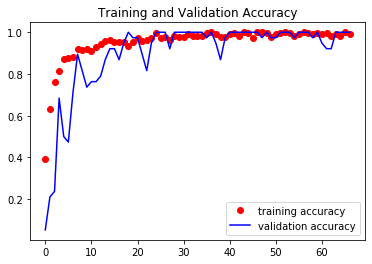

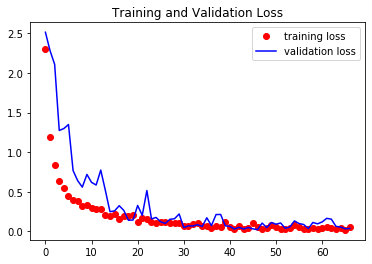

In [8]:
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, 'bo', color='r', label='training accuracy')
plt.plot(val_acc, 'b', color='b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, 'bo', color='r', label='training loss')
plt.plot(val_loss, 'b', color='b', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


[ 1.  7.  2.  4. 14.  5.  5.  7.  3. 10.]
[4.2952597e-03 8.8233763e-01 5.5573702e-02 3.9241093e-04 1.9798568e-03
 6.1476487e-03 2.3915156e-05 4.9234306e-05 1.7079742e-03 2.9067133e-04
 3.8571350e-02 1.1945923e-03 3.7879657e-03 3.3840213e-05 3.6139716e-03]
Confusion Matrix
[ 1  7  2  4 14  5  5  7  3 10]


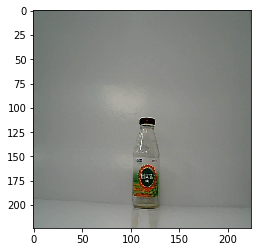

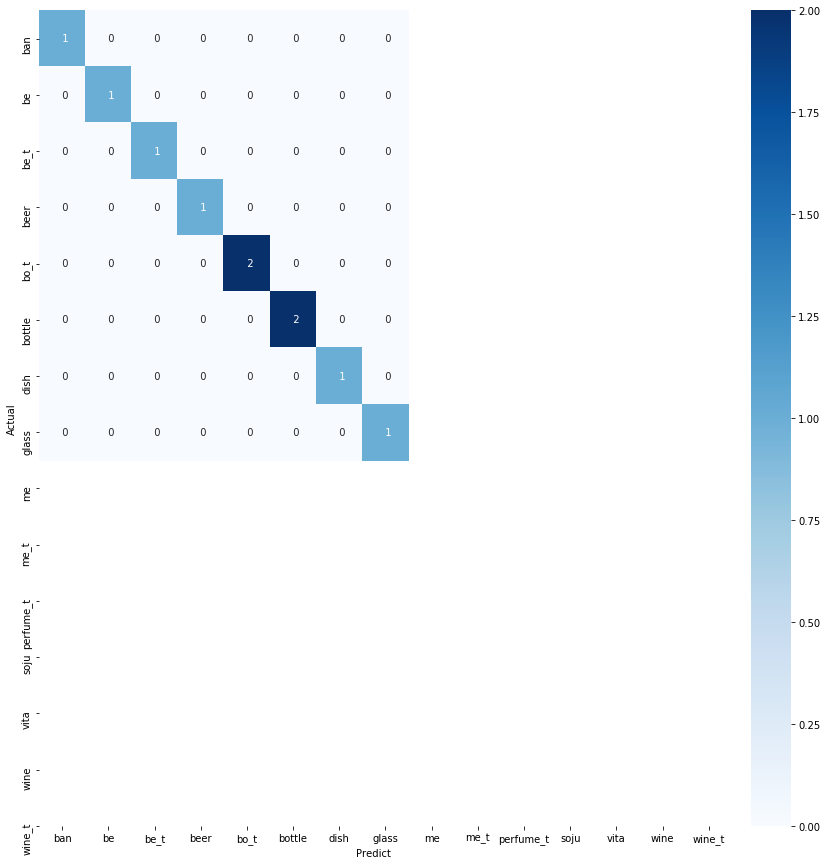

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with tf.device('/device:GPU:0'):


    model_path = '../model/recycle_vgg16_fine_image1_1211.h5'


    vgg_model = tf.keras.models.load_model(model_path)


    x_train, y_train= validationGen.next()
    print(y_train)
    plt.imshow(x_train[0])

    #Confution Matrix and Classification Report
    Y_pred = vgg_model.predict_generator(validationGen, 1)
    
    print(Y_pred[0])

    y_pred = np.argmax(Y_pred, axis=1)


    print('Confusion Matrix')
    # display(confusion_matrix(validationGen.classes, y_pred))

    print(y_pred)





    fig, ax = plt.subplots(figsize=(15,15))  # inch단위로 그림의 크기
    sns.heatmap(
        confusion_matrix(y_train, y_pred),
        annot = True, # 숫자표현
        fmt = '3d',    # 정수표현     
        cmap = 'Blues', # color 색상
        ax = ax,       # 그래프로 사용할 subplot
        xticklabels=category_csv['bottle_name'], 
        yticklabels=category_csv['bottle_name']
    )
    ax.set_xlabel('Predict')
    ax.set_ylabel('Actual')
    plt.show()